In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 设置TensorFlow日志级别为"ERROR"
import tensorflow as tf
import numpy as np

## 1 准备数据

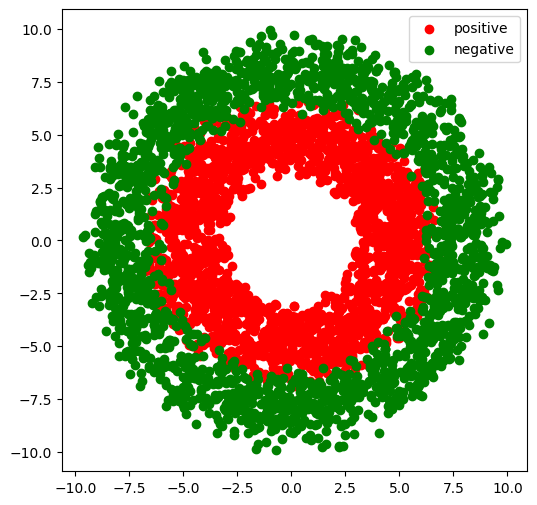

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)

#样本洗牌
data = tf.concat([X,Y],axis = 1)
data = tf.random.shuffle(data)
X = data[:,:2]
Y = data[:,2:]


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [3]:
n= n_positive + n_negative
ds_train = tf.data.Dataset.from_tensor_slices((X[0:n*3//4,:],Y[0:n*3//4,:])) \
     .shuffle(buffer_size = 1000).batch(20, drop_remainder=True) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

ds_valid = tf.data.Dataset.from_tensor_slices((X[n*3//4:,:],Y[n*3//4:,:])) \
     .batch(20, drop_remainder=True) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

## 2 定义模型

In [4]:
tf.keras.backend.clear_session()
class DNNModel(tf.keras.models.Model):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(4,activation = "relu",name = "dense1") 
        self.dense2 = tf.keras.layers.Dense(8,activation = "relu",name = "dense2")
        self.dense3 = tf.keras.layers.Dense(1,activation = "sigmoid",name = "dense3")
    # def build(self,input_shape):
    #     self.dense1 = tf.keras.layers.Dense(4,activation = "relu",name = "dense1") 
    #     self.dense2 = tf.keras.layers.Dense(8,activation = "relu",name = "dense2")
    #     self.dense3 = tf.keras.layers.Dense(1,activation = "sigmoid",name = "dense3")
    #     #super(DNNModel,self).build(input_shape)
 
    def call(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y

model = DNNModel()


## 3 训练模型

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_func = tf.keras.losses.BinaryCrossentropy()
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_metric = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_metric = tf.keras.metrics.BinaryAccuracy(name='valid_accuracy')

In [6]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        #print("predictions", predictions.shape)
        loss = loss_func(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)

@tf.function
def valid_step(model, features, labels):
    #print("valid_step",features.shape, labels.shape)
    predictions = model(features)
    #print('predictions',predictions.shape)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)
    #print('run valid_step successfully')
    

def train_model(model,ds_train,ds_valid,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in ds_train:
            #print(features.shape, labels.shape)
            train_step(model,features,labels)
        #print("begin to run valid_step")
        for features, labels in ds_valid:
            #print(features.shape, labels.shape)
            valid_step(model,features,labels)

        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'
        
        if  epoch%100 ==0:
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
        
        train_loss.reset_state()
        valid_loss.reset_state()
        train_metric.reset_state()
        valid_metric.reset_state()
train_model(model,ds_train,ds_valid,1000)

Epoch=100,Loss:0.112187371,Accuracy:0.95266664,Valid Loss:0.114135362,Valid Accuracy:0.946
Epoch=200,Loss:0.108368874,Accuracy:0.95266664,Valid Loss:0.116458721,Valid Accuracy:0.946
Epoch=300,Loss:0.106733821,Accuracy:0.952,Valid Loss:0.116942,Valid Accuracy:0.944
Epoch=400,Loss:0.104762278,Accuracy:0.953,Valid Loss:0.117319509,Valid Accuracy:0.943
Epoch=500,Loss:0.103888676,Accuracy:0.953,Valid Loss:0.118720442,Valid Accuracy:0.944
Epoch=600,Loss:0.104059875,Accuracy:0.95266664,Valid Loss:0.115178302,Valid Accuracy:0.95
Epoch=700,Loss:0.102084644,Accuracy:0.952333331,Valid Loss:0.11568816,Valid Accuracy:0.947
Epoch=800,Loss:0.102069221,Accuracy:0.953333318,Valid Loss:0.112498492,Valid Accuracy:0.949
Epoch=900,Loss:0.102520347,Accuracy:0.952333331,Valid Loss:0.112468168,Valid Accuracy:0.948
Epoch=1000,Loss:0.102273829,Accuracy:0.953333318,Valid Loss:0.116825312,Valid Accuracy:0.945


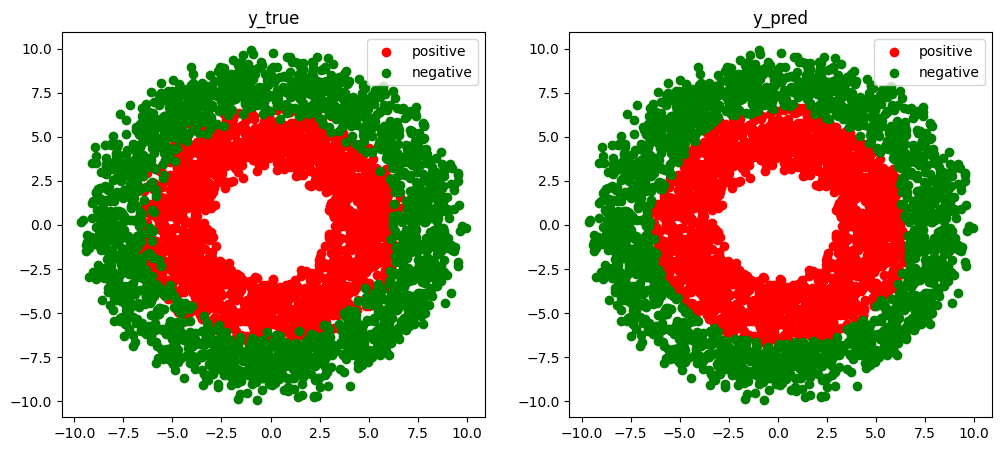

In [7]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");